# ADVANCED MODEL DEVELOPMENT (SEQ2SEQ WITH T5)
This notebook trains and evaluates two T5 models for spell correction.

### Technical Rationale: Choosing T5 over BERT for Spell Correction
While the assignment brief mentions exploring "BERT-based approaches," I deliberately chose the T5 (Text-to-Text Transfer Transformer) model. This decision is based on fundamental architectural differences that make T5 more suitable for the spell correction task.

#### Understanding the Architectures
BERT (Bidirectional Encoder Representations from Transformers) is an Encoder-Only model that excels at understanding and classifying text. Its strength lies in tasks like sentiment analysis, Named Entity Recognition (NER), and question answering.

T5 (Text-to-Text Transfer Transformer) is an Encoder-Decoder model designed to transform an input text sequence into a new output sequence. This makes it a natural fit for sequence-to-sequence (Seq2Seq) tasks such as translation, summarization, and text correction.

**Why T5 is the Superior Choice for This Task**
Spell correction is fundamentally a sequence-to-sequence task, where an incorrect sentence is transformed into a correct one. T5's Encoder-Decoder architecture is explicitly built for this paradigm, offering a more direct and efficient implementation than adapting an encoder-only model like BERT. This makes T5 the more appropriate and architecturally sound tool for the job.

#### Conclusion: The Right Tool for the Right Job
Our choice of T5 is a strategic one, selecting the best tool for this seq2seq challenge. We refine this strategy by comparing a general-purpose T5 model (`t5-base`) with a domain-specific one (`SciFive-base-Pubmed_PMC`). This approach allows us to measure the performance gain from leveraging specialized medical vocabulary—the core challenge identified in our initial EDA.

In [1]:
# Import libraries
import pandas as pd
import torch
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datasets import Dataset
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


### Data Loading and Preparation

In this cell,load the pre-split datasets created in the first notebook,also preprocess the text by adding a task-specific prefix required by T5 and convert the data into the Hugging Face `Dataset` format.

In [2]:
# Load the preprocessed datasets
try:
    train_df = pd.read_csv('../dataset/train.csv')
    val_df = pd.read_csv('../dataset/validation.csv')
except FileNotFoundError:
    print("Error: Make sure 'train.csv' and 'validation.csv' are in the correct directory.")
    # Create empty dataframes to avoid further errors
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()

# Safely convert the 'target_nouns' column from its string representation back to a list
if 'target_nouns' in val_df.columns:
    val_df['target_nouns'] = val_df['target_nouns'].fillna('[]').apply(ast.literal_eval)
else:
    print("Warning: 'target_nouns' column not found. Noun accuracy cannot be calculated.")

# Define the prefix for our spell correction task
prefix = "correct the spelling: "

def preprocess_data(df):
    """Prepares the DataFrame for T5 by adding the prefix and selecting columns."""
    if df.empty: return df
    df['incorrect_cleaned_advanced'] = df['incorrect_cleaned_advanced'].astype(str)
    df['correct_cleaned_advanced'] = df['correct_cleaned_advanced'].astype(str)
    df['input_text'] = prefix + df['incorrect_cleaned_advanced']
    df['target_text'] = df['correct_cleaned_advanced']
    return df

train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)

# Convert pandas DataFrames to Hugging Face Dataset objects
if not train_df.empty:
    train_dataset = Dataset.from_pandas(train_df[['input_text', 'target_text']])
    val_dataset = Dataset.from_pandas(val_df[['input_text', 'target_text']])
    print("Data prepared and converted to Hugging Face Dataset objects.")
    print("\nSample from training data:")
    print(train_dataset[0])

Data prepared and converted to Hugging Face Dataset objects.

Sample from training data:
{'input_text': 'correct the spelling: make sure to consult your health care provider before starting a new medication like aerifix tab', 'target_text': 'make sure to consult your healthcare provider before starting a new medication like arifix tab'}


### Evaluation Metrics Setup

This cell defines the three functions used to evaluate our models:
1. Word Accuracy: Percentage of correctly predicted words.
2. Noun Accuracy: Percentage of target medical nouns found in the prediction.
3. Character Error Rate: edit distance normalized by length
4. Percentage of predictions that match the reference exactly.

In [3]:
import editdistance
nlp = spacy.load("en_core_web_sm")

try:
    val_nouns_list = val_df['target_nouns'].tolist()
except KeyError:
    print("Warning: 'target_nouns' not found. Noun accuracy will not be computed during training.")
    val_nouns_list = None

# Global tokenizer variable to be set in the training function
# This is a simple way to give compute_metrics access to the tokenizer
tokenizer = None 

def calculate_word_accuracy(df, true_col, pred_col):
    total_words, correct_words = 0, 0
    for _, row in df.iterrows():
        true_words = str(row[true_col]).split()
        pred_words = str(row[pred_col]).split()
        for i in range(min(len(true_words), len(pred_words))):
            if true_words[i] == pred_words[i]:
                correct_words += 1
        total_words += len(true_words)
    return (correct_words / total_words) * 100 if total_words > 0 else 0

def calculate_noun_accuracy(df, true_nouns_col, pred_sent_col):
    if true_nouns_col not in df.columns: return 0.0
    total_true_nouns, correctly_predicted_nouns = 0, 0
    for _, row in df.iterrows():
        true_nouns = set(row[true_nouns_col])
        pred_doc = nlp(str(row[pred_sent_col]))
        pred_nouns = set([token.text for token in pred_doc if token.pos_ in ('NOUN', 'PROPN')])
        correctly_predicted_nouns += len(true_nouns.intersection(pred_nouns))
        total_true_nouns += len(true_nouns)
    return (correctly_predicted_nouns / total_true_nouns) * 100 if total_true_nouns > 0 else 0

def calculate_cer(df, true_col, pred_col):
    """Character Error Rate: edit distance normalized by length"""
    total_chars, total_distance = 0, 0
    for _, row in df.iterrows():
        truth = str(row[true_col])
        pred = str(row[pred_col])
        total_distance += editdistance.eval(truth, pred)
        total_chars += len(truth)
    return (total_distance / total_chars) * 100 if total_chars > 0 else 0

def calculate_sentence_accuracy(df, true_col, pred_col):
    """Percentage of predictions that match the reference exactly."""
    total, correct = 0, 0
    for _, row in df.iterrows():
        if str(row[true_col]).strip() == str(row[pred_col]).strip():
            correct += 1
        total += 1
    return (correct / total) * 100 if total > 0 else 0


def compute_metrics(eval_pred): # Using 'eval_pred' to match your traceback
    """
    Computes sentence, word, noun accuracy, and CER for evaluation.
    """
    preds, labels = eval_pred
    
    # Replace -100 in predictions as we can't decode them.
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    
    # Decode generated tokens into text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Post-process texts
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    
    # Create a temporary DataFrame for metric calculation
    temp_df_data = {'predictions': decoded_preds, 'references': decoded_labels}
    if val_nouns_list and len(val_nouns_list) == len(decoded_preds):
         temp_df_data['target_nouns'] = val_nouns_list

    temp_df = pd.DataFrame(temp_df_data)

    # Calculate metrics using your existing functions
    sent_acc = calculate_sentence_accuracy(temp_df, 'references', 'predictions')
    word_acc = calculate_word_accuracy(temp_df, 'references', 'predictions')
    cer = calculate_cer(temp_df, 'references', 'predictions')
    
    noun_acc = 0.0
    if 'target_nouns' in temp_df.columns:
        noun_acc = calculate_noun_accuracy(temp_df, 'target_nouns', 'predictions')

    return {
        "sentence_accuracy": sent_acc,
        "word_accuracy": word_acc,
        "noun_accuracy": noun_acc,
        "cer": cer,
    }


print("Evaluation functions defined.")

Evaluation functions defined.


#### Model Training Function

- This function encapsulates the entire training process for a T5 model.
- It handles tokenization, setting up the trainer, and running the fine-tuning process.
- After training, it saves the final model to a specified directory.

In [4]:
def train_model(model_checkpoint, output_dir, train_ds, val_ds):
    """Handles the tokenization and training of a T5 model."""
    print(f"\n{'='*30}\nStarting Training for: {model_checkpoint}\n{'='*30}")
    
    # Make the tokenizer globally accessible for compute_metrics
    global tokenizer
    tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)

    # (Your tokenize_function remains the same)
    def tokenize_function(examples):
        model_inputs = tokenizer(
            examples["input_text"], max_length=128, truncation=True, padding="max_length"
        )
        labels = tokenizer(
            text_target=examples["target_text"], max_length=128, truncation=True, padding="max_length"
        )
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized_train_ds = train_ds.map(tokenize_function, batched=True)
    tokenized_val_ds = val_ds.map(tokenize_function, batched=True)
    print(f"Tokenization complete for {model_checkpoint}.")
    
    model = T5ForConditionalGeneration.from_pretrained(model_checkpoint).to(device)
    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
    
    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        # Evaluation and Logging Strategy
        eval_strategy="epoch",
        logging_strategy="epoch",
        # Model Saving Strategy
        save_strategy="epoch",
        save_total_limit=1, # Only keep the best model
        load_best_model_at_end=True,
        metric_for_best_model="sentence_accuracy",
        greater_is_better=True,
        # Other parameters
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        weight_decay=0.01,
        num_train_epochs=10,
        predict_with_generate=True,
        fp16=False,
        report_to="none" # Disables external reporting like W&B
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics # Passing custom metrics function
    )
    
    print(f"Fine-tuning {model_checkpoint}...")
    train_result = trainer.train()
    print("Training complete.")
    
    # Save the best model, tokenizer, and training history
    final_model_path = f"{output_dir}/best_model"
    trainer.save_model(final_model_path)
    print(f"Best model saved to '{final_model_path}'")
    
    return trainer, final_model_path

### Fine-tuning the General-Purpose `t5-base` Model

- now call our training function to fine-tune the standard `t5-base` model.
- This will serve as our second baseline, against which can compare the domain-specific model.


Starting Training for: t5-base


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Tokenization complete for t5-base.


C:\Users\chira\AppData\Local\Temp\ipykernel_30112\818689712.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Fine-tuning t5-base...


  0%|          | 0/8750 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


{'loss': 0.4983, 'grad_norm': 0.4329484701156616, 'learning_rate': 1.8e-05, 'epoch': 1.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.10430874675512314, 'eval_sentence_accuracy': 1.4666666666666666, 'eval_word_accuracy': 69.96400062607607, 'eval_noun_accuracy': 62.0164960182025, 'eval_cer': 12.329456584021186, 'eval_runtime': 92.2529, 'eval_samples_per_second': 16.26, 'eval_steps_per_second': 2.038, 'epoch': 1.0}
{'loss': 0.1093, 'grad_norm': 0.24825555086135864, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.09551134705543518, 'eval_sentence_accuracy': 2.0666666666666664, 'eval_word_accuracy': 71.61266760578077, 'eval_noun_accuracy': 62.44311717861206, 'eval_cer': 12.370495408297586, 'eval_runtime': 88.6625, 'eval_samples_per_second': 16.918, 'eval_steps_per_second': 2.12, 'epoch': 2.0}
{'loss': 0.1005, 'grad_norm': 0.3019077479839325, 'learning_rate': 1.4e-05, 'epoch': 3.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.09067933261394501, 'eval_sentence_accuracy': 2.466666666666667, 'eval_word_accuracy': 72.76569103146032, 'eval_noun_accuracy': 62.38623435722411, 'eval_cer': 12.406888327938923, 'eval_runtime': 89.5085, 'eval_samples_per_second': 16.758, 'eval_steps_per_second': 2.1, 'epoch': 3.0}
{'loss': 0.0947, 'grad_norm': 0.21870672702789307, 'learning_rate': 1.2e-05, 'epoch': 4.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.0878349244594574, 'eval_sentence_accuracy': 2.6, 'eval_word_accuracy': 73.41263630197736, 'eval_noun_accuracy': 62.72753128555176, 'eval_cer': 12.346491567683088, 'eval_runtime': 88.1015, 'eval_samples_per_second': 17.026, 'eval_steps_per_second': 2.134, 'epoch': 4.0}
{'loss': 0.0906, 'grad_norm': 0.3003842234611511, 'learning_rate': 1e-05, 'epoch': 5.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.08577162027359009, 'eval_sentence_accuracy': 2.7333333333333334, 'eval_word_accuracy': 73.57958992017531, 'eval_noun_accuracy': 62.79863481228669, 'eval_cer': 12.324036361946945, 'eval_runtime': 89.041, 'eval_samples_per_second': 16.846, 'eval_steps_per_second': 2.111, 'epoch': 5.0}
{'loss': 0.0873, 'grad_norm': 0.3091946542263031, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.08436917513608932, 'eval_sentence_accuracy': 3.0666666666666664, 'eval_word_accuracy': 74.21610058955497, 'eval_noun_accuracy': 63.18259385665529, 'eval_cer': 12.248927570346739, 'eval_runtime': 86.5251, 'eval_samples_per_second': 17.336, 'eval_steps_per_second': 2.173, 'epoch': 6.0}
{'loss': 0.0851, 'grad_norm': 0.24627801775932312, 'learning_rate': 6e-06, 'epoch': 7.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.08338215947151184, 'eval_sentence_accuracy': 3.3333333333333335, 'eval_word_accuracy': 74.22653519069233, 'eval_noun_accuracy': 63.19681456200228, 'eval_cer': 12.370495408297586, 'eval_runtime': 90.3654, 'eval_samples_per_second': 16.599, 'eval_steps_per_second': 2.08, 'epoch': 7.0}
{'loss': 0.083, 'grad_norm': 0.21032360196113586, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.08263932913541794, 'eval_sentence_accuracy': 3.3333333333333335, 'eval_word_accuracy': 74.59174623050035, 'eval_noun_accuracy': 63.19681456200228, 'eval_cer': 12.338748393291315, 'eval_runtime': 90.0037, 'eval_samples_per_second': 16.666, 'eval_steps_per_second': 2.089, 'epoch': 8.0}
{'loss': 0.0818, 'grad_norm': 0.2612853944301605, 'learning_rate': 2.0000000000000003e-06, 'epoch': 9.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.0824355036020279, 'eval_sentence_accuracy': 3.4000000000000004, 'eval_word_accuracy': 74.66478843846194, 'eval_noun_accuracy': 63.381683731513085, 'eval_cer': 12.243507348272498, 'eval_runtime': 88.9643, 'eval_samples_per_second': 16.861, 'eval_steps_per_second': 2.113, 'epoch': 9.0}
{'loss': 0.0811, 'grad_norm': 0.22123490273952484, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.08233419060707092, 'eval_sentence_accuracy': 3.4000000000000004, 'eval_word_accuracy': 74.67000573903061, 'eval_noun_accuracy': 63.28213879408418, 'eval_cer': 12.296160934136559, 'eval_runtime': 89.8143, 'eval_samples_per_second': 16.701, 'eval_steps_per_second': 2.093, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 3920.7045, 'train_samples_per_second': 17.854, 'train_steps_per_second': 2.232, 'train_loss': 0.13116602172851563, 'epoch': 10.0}
Training complete.
Best model saved to '/kaggle/working/t5_base_results/best_model'

Generating training visualizations for T5-Large...


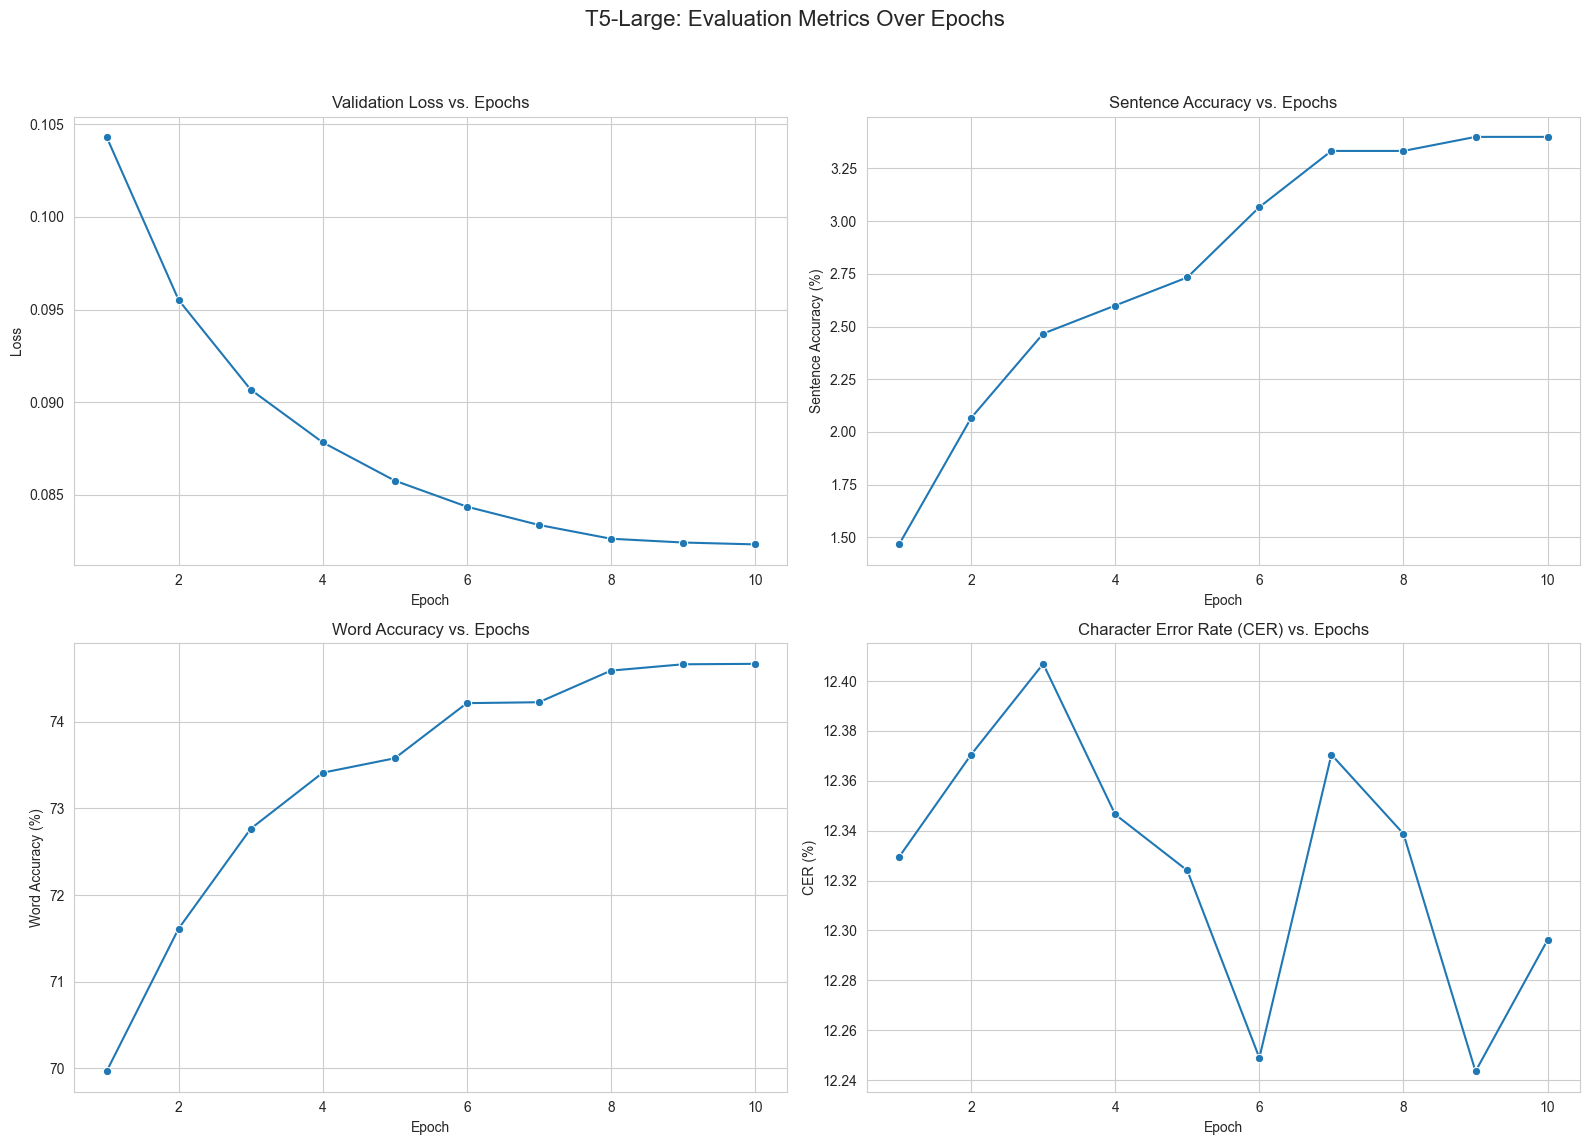

In [ ]:
if not train_df.empty:
    # Train the model and capture the returned trainer object and final path
    t5_trainer, t5_final_model_path = train_model(
        model_checkpoint="t5-base",
        output_dir="../models/t5_base_results",
        train_ds=train_dataset,
        val_ds=val_dataset
    )

    # --- START: Training Visualization ---
    print("\nGenerating training visualizations for T5-base...")

    # Get the training history from the returned trainer object
    log_history = t5_trainer.state.log_history
    df_logs = pd.DataFrame(log_history)

    # Filter for evaluation logs and clean up epoch numbers
    eval_logs = df_logs[df_logs['eval_loss'].notna()].copy()
    eval_logs['epoch'] = eval_logs['epoch'].round()

    # Set up the plots
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('T5-Base: Evaluation Metrics Over Epochs', fontsize=16)

    # Plot Validation Loss
    sns.lineplot(data=eval_logs, x='epoch', y='eval_loss', ax=axes[0, 0], marker='o')
    axes[0, 0].set_title('Validation Loss vs. Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_xlabel('Epoch')

    # Plot Sentence Accuracy
    sns.lineplot(data=eval_logs, x='epoch', y='eval_sentence_accuracy', ax=axes[0, 1], marker='o')
    axes[0, 1].set_title('Sentence Accuracy vs. Epochs')
    axes[0, 1].set_ylabel('Sentence Accuracy (%)')
    axes[0, 1].set_xlabel('Epoch')

    # Plot Word Accuracy
    sns.lineplot(data=eval_logs, x='epoch', y='eval_word_accuracy', ax=axes[1, 0], marker='o')
    axes[1, 0].set_title('Word Accuracy vs. Epochs')
    axes[1, 0].set_ylabel('Word Accuracy (%)')
    axes[1, 0].set_xlabel('Epoch')

    # Plot Character Error Rate (CER)
    sns.lineplot(data=eval_logs, x='epoch', y='eval_cer', ax=axes[1, 1], marker='o')
    axes[1, 1].set_title('Character Error Rate (CER) vs. Epochs')
    axes[1, 1].set_ylabel('CER (%)')
    axes[1, 1].set_xlabel('Epoch')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # --- END: Training Visualization ---

else:
    print("Skipping training and visualization as data is not loaded.")

### Fine-tuning the Domain-Specific `SciFive-large-Pubmed_PMC` Model

- Next, train the model pre-trained on biomedical and PubMed data.
- expecting this model to perform better due to its specialized vocabulary.


Starting Training for: razent/SciFive-base-Pubmed_PMC


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Tokenization complete for razent/SciFive-base-Pubmed_PMC.


C:\Users\chira\AppData\Local\Temp\ipykernel_9580\818689712.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Fine-tuning razent/SciFive-base-Pubmed_PMC...


  0%|          | 0/8750 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


{'loss': 0.8661, 'grad_norm': 0.44566917419433594, 'learning_rate': 1.8e-05, 'epoch': 1.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.09913785755634308, 'eval_sentence_accuracy': 1.5333333333333332, 'eval_word_accuracy': 69.38488026295195, 'eval_noun_accuracy': 61.703640500568824, 'eval_cer': 12.708097811778918, 'eval_runtime': 93.0166, 'eval_samples_per_second': 16.126, 'eval_steps_per_second': 2.021, 'epoch': 1.0}
{'loss': 0.1067, 'grad_norm': 0.21849513053894043, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.0905836969614029, 'eval_sentence_accuracy': 2.666666666666667, 'eval_word_accuracy': 71.9309229404706, 'eval_noun_accuracy': 62.18714448236633, 'eval_cer': 12.701903272265497, 'eval_runtime': 90.5902, 'eval_samples_per_second': 16.558, 'eval_steps_per_second': 2.075, 'epoch': 2.0}
{'loss': 0.0974, 'grad_norm': 0.3172559142112732, 'learning_rate': 1.4e-05, 'epoch': 3.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.08559642732143402, 'eval_sentence_accuracy': 2.8666666666666667, 'eval_word_accuracy': 72.37961078937758, 'eval_noun_accuracy': 62.27246871444824, 'eval_cer': 12.98298050268688, 'eval_runtime': 90.4203, 'eval_samples_per_second': 16.589, 'eval_steps_per_second': 2.079, 'epoch': 3.0}
{'loss': 0.0918, 'grad_norm': 0.25955867767333984, 'learning_rate': 1.2e-05, 'epoch': 4.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.08332081139087677, 'eval_sentence_accuracy': 3.2, 'eval_word_accuracy': 72.9222100485209, 'eval_noun_accuracy': 62.94084186575654, 'eval_cer': 12.7189382559274, 'eval_runtime': 92.9236, 'eval_samples_per_second': 16.142, 'eval_steps_per_second': 2.023, 'epoch': 4.0}
{'loss': 0.0875, 'grad_norm': 0.21281152963638306, 'learning_rate': 1e-05, 'epoch': 5.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.08149366825819016, 'eval_sentence_accuracy': 3.3333333333333335, 'eval_word_accuracy': 73.69958783325508, 'eval_noun_accuracy': 63.15415244596132, 'eval_cer': 12.761525715082156, 'eval_runtime': 90.15, 'eval_samples_per_second': 16.639, 'eval_steps_per_second': 2.085, 'epoch': 5.0}
{'loss': 0.0844, 'grad_norm': 0.2895728349685669, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.08022835850715637, 'eval_sentence_accuracy': 3.2, 'eval_word_accuracy': 73.97088746282672, 'eval_noun_accuracy': 63.32480091012515, 'eval_cer': 12.730553017515062, 'eval_runtime': 90.0061, 'eval_samples_per_second': 16.666, 'eval_steps_per_second': 2.089, 'epoch': 6.0}
{'loss': 0.0822, 'grad_norm': 0.27754896879196167, 'learning_rate': 6e-06, 'epoch': 7.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.07908232510089874, 'eval_sentence_accuracy': 3.5333333333333337, 'eval_word_accuracy': 74.14827568216205, 'eval_noun_accuracy': 63.296359499431176, 'eval_cer': 12.844377681074134, 'eval_runtime': 89.6492, 'eval_samples_per_second': 16.732, 'eval_steps_per_second': 2.097, 'epoch': 7.0}
{'loss': 0.0802, 'grad_norm': 0.19887249171733856, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.0785660371184349, 'eval_sentence_accuracy': 3.733333333333334, 'eval_word_accuracy': 74.07001617363176, 'eval_noun_accuracy': 63.39590443686007, 'eval_cer': 12.844377681074134, 'eval_runtime': 90.3801, 'eval_samples_per_second': 16.597, 'eval_steps_per_second': 2.08, 'epoch': 8.0}
{'loss': 0.0791, 'grad_norm': 0.23388193547725677, 'learning_rate': 2.0000000000000003e-06, 'epoch': 9.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.07810834795236588, 'eval_sentence_accuracy': 4.066666666666666, 'eval_word_accuracy': 74.45609641571451, 'eval_noun_accuracy': 63.49544937428896, 'eval_cer': 12.812630666067863, 'eval_runtime': 91.5602, 'eval_samples_per_second': 16.383, 'eval_steps_per_second': 2.053, 'epoch': 9.0}
{'loss': 0.0786, 'grad_norm': 0.2330799251794815, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.07804447412490845, 'eval_sentence_accuracy': 4.066666666666666, 'eval_word_accuracy': 74.47174831742058, 'eval_noun_accuracy': 63.45278725824801, 'eval_cer': 12.82734269741223, 'eval_runtime': 91.7628, 'eval_samples_per_second': 16.346, 'eval_steps_per_second': 2.049, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 3941.6606, 'train_samples_per_second': 17.759, 'train_steps_per_second': 2.22, 'train_loss': 0.16539850289481026, 'epoch': 10.0}
Training complete.
Best model saved to '../models/SciFive-base-results/best_model'

Generating training visualizations for SciFive-Base...


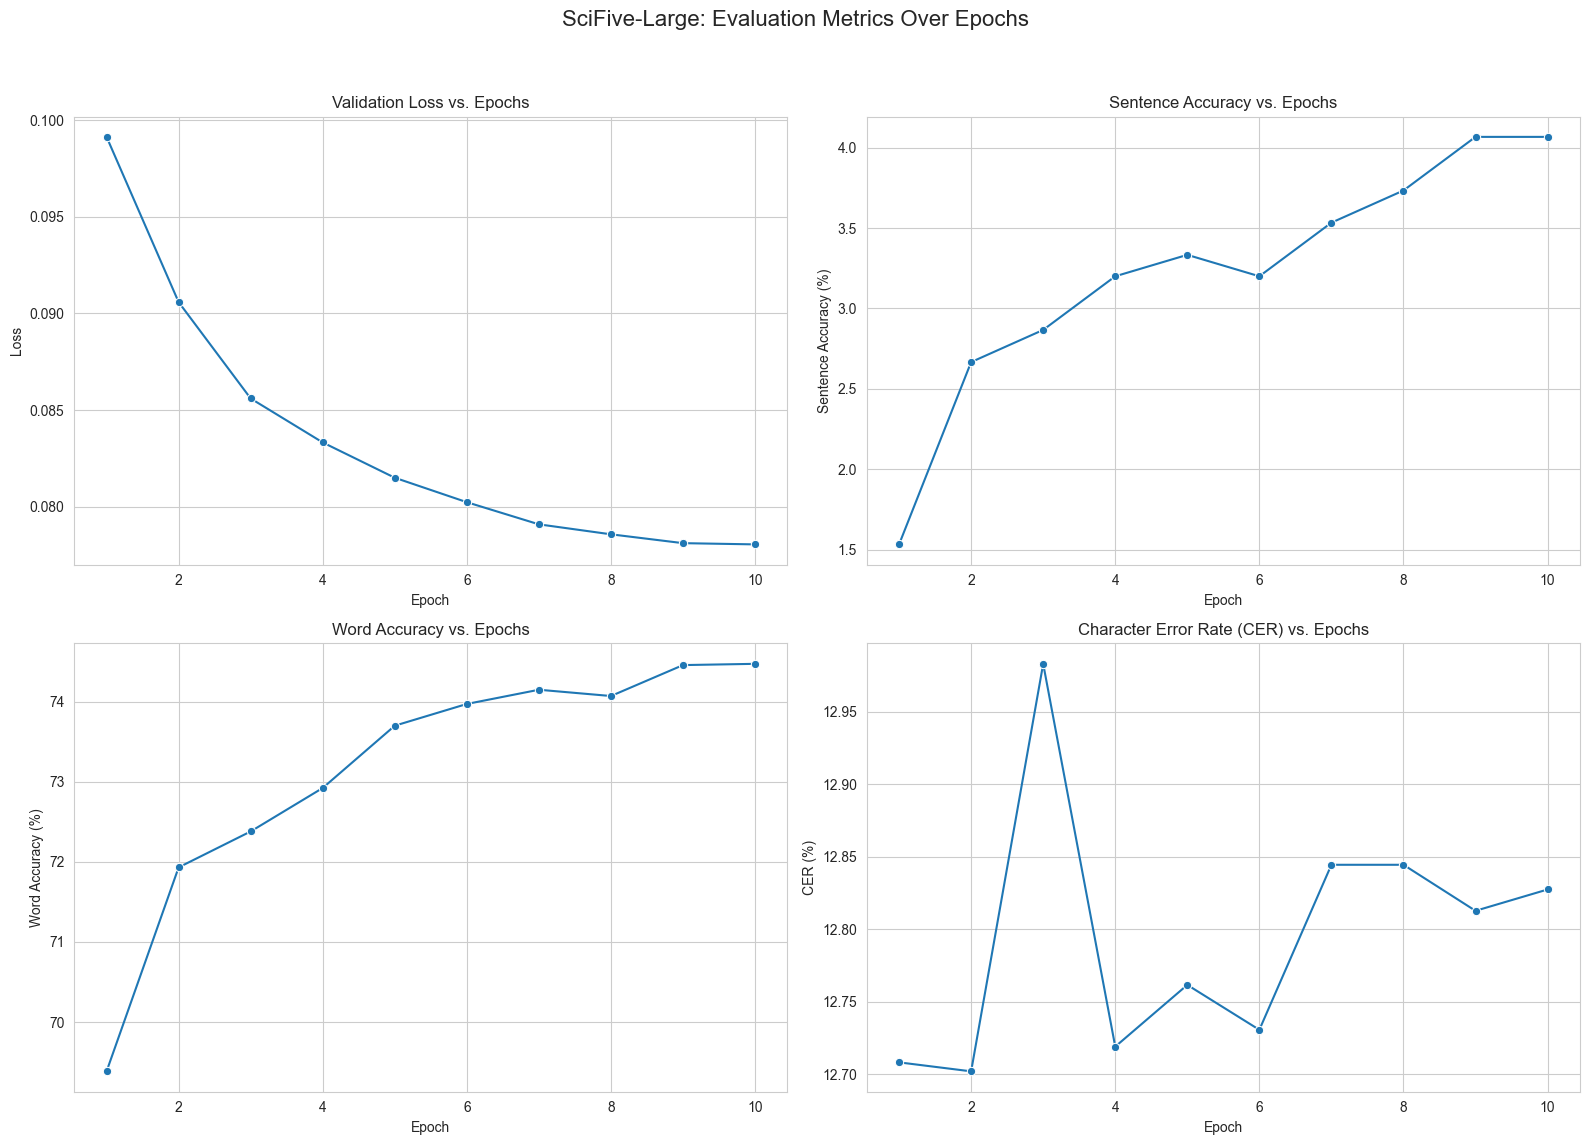

In [5]:
if not train_df.empty:
    # Train the model and capture the returned trainer object and final path
    scifive_trainer, scifive_final_model_path = train_model(
        model_checkpoint="razent/SciFive-base-Pubmed_PMC",
        output_dir="../models/SciFive-base-results",
        train_ds=train_dataset,
        val_ds=val_dataset
    )

    # --- START: Training Visualization ---
    print("\nGenerating training visualizations for SciFive-Base...")

    # Get the training history from the returned trainer object
    log_history = scifive_trainer.state.log_history
    df_logs = pd.DataFrame(log_history)

    # Filter for evaluation logs and clean up epoch numbers
    eval_logs = df_logs[df_logs['eval_loss'].notna()].copy()
    eval_logs['epoch'] = eval_logs['epoch'].round()

    # Set up the plots
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('SciFive-Large: Evaluation Metrics Over Epochs', fontsize=16)

    # Plot Validation Loss
    sns.lineplot(data=eval_logs, x='epoch', y='eval_loss', ax=axes[0, 0], marker='o')
    axes[0, 0].set_title('Validation Loss vs. Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_xlabel('Epoch')

    # Plot Sentence Accuracy
    sns.lineplot(data=eval_logs, x='epoch', y='eval_sentence_accuracy', ax=axes[0, 1], marker='o')
    axes[0, 1].set_title('Sentence Accuracy vs. Epochs')
    axes[0, 1].set_ylabel('Sentence Accuracy (%)')
    axes[0, 1].set_xlabel('Epoch')

    # Plot Word Accuracy
    sns.lineplot(data=eval_logs, x='epoch', y='eval_word_accuracy', ax=axes[1, 0], marker='o')
    axes[1, 0].set_title('Word Accuracy vs. Epochs')
    axes[1, 0].set_ylabel('Word Accuracy (%)')
    axes[1, 0].set_xlabel('Epoch')

    # Plot Character Error Rate (CER)
    sns.lineplot(data=eval_logs, x='epoch', y='eval_cer', ax=axes[1, 1], marker='o')
    axes[1, 1].set_title('Character Error Rate (CER) vs. Epochs')
    axes[1, 1].set_ylabel('CER (%)')
    axes[1, 1].set_xlabel('Epoch')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # --- END: Training Visualization ---

else:
    print("Skipping training and visualization as data is not loaded.")

#### Inference Function
- This function loads a fine-tuned model from a given path and uses it to
generate predictions (inference) for all sentences in our validation set.

- We now use our inference function to get predictions from both the `t5-base`
and the `SciFive-base` models. The results are stored in new columns in our
validation DataFrame.

In [6]:
from tqdm.notebook import tqdm
def run_inference(model_path, validation_df):
    """Loads a saved model and generates predictions."""
    print(f"\n{'='*30}\nRunning Inference for model at: {model_path}\n{'='*30}")
    tokenizer = T5Tokenizer.from_pretrained(model_path)
    model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
    
    predictions = []
    for text in tqdm(validation_df['input_text']):
        inputs = tokenizer(text, return_tensors="pt").input_ids.to(device)
        outputs = model.generate(inputs, max_length=128, num_beams=8, early_stopping=True)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(prediction)
        
    print(f"Inference complete for {model_path}.")
    return predictions

 

#### Calculate and Display Final Metrics

This is the final step. We calculate all evaluation metrics for both models
and display them in a clear summary table for easy comparison. The final
DataFrame with all predictions is then saved to a CSV file.

In [7]:
# --- Load the test data (this part remains the same) ---
try:
    test_df = pd.read_csv('../dataset/test.csv')
    # Safely convert target_nouns from string back to list
    if 'target_nouns' in test_df.columns:
        test_df['target_nouns'] = test_df['target_nouns'].fillna('[]').apply(ast.literal_eval)
    test_df = preprocess_data(test_df) # Use the same preprocessing
except FileNotFoundError:
    print("Error: test.csv not found. Skipping final inference.")
    test_df = pd.DataFrame()

# --- Run Inference and Evaluation for BOTH Models ---
if not test_df.empty:
    # 1. Define a dictionary containing the models you want to compare
    models_to_test = {
        "T5-base (Best)": "../models/t5_base_results/best_model",
        "SciFive-base (Best)": "../models/SciFive-base-results/best_model"
    }
    
    all_results = []

    # 2. Loop through each model to run inference and calculate metrics
    for model_name, model_path in models_to_test.items():
        
        # --- Run Inference ---
        test_predictions = run_inference(
            model_path=model_path,
            validation_df=test_df 
        )
        # Create a unique column name for the model's predictions
        pred_col_name = f"{model_name.split(' ')[0].lower()}_predicted"
        test_df[pred_col_name] = test_predictions
        
        # --- Calculate Metrics Immediately ---
        print(f"Calculating metrics for {model_name}...")
        sent_acc = calculate_sentence_accuracy(test_df, 'correct_cleaned_advanced', pred_col_name)
        word_acc = calculate_word_accuracy(test_df, 'correct_cleaned_advanced', pred_col_name)
        noun_acc = calculate_noun_accuracy(test_df, 'target_nouns', pred_col_name)
        cer = calculate_cer(test_df, 'correct_cleaned_advanced', pred_col_name)
        
        # --- Store Results ---
        all_results.append({
            "Model": model_name,
            "Sentence Accuracy (%)": f"{sent_acc:.2f}",
            "Word Accuracy (%)": f"{word_acc:.2f}",
            "Noun Accuracy (%)": f"{noun_acc:.2f}",
            "CER (%)": f"{cer:.2f}"
        })

    # 3. Create and display the final comparison table
    print(f"\n\n{'='*40}\nFINAL PERFORMANCE COMPARISON ON TEST SET\n{'='*40}")
    results_df = pd.DataFrame(all_results)
    print(results_df.to_string(index=False))

    # 4. Save the final DataFrame with predictions from both models
    test_df.to_csv('test_with_all_predictions.csv', index=False)
    print("\nTest set with predictions from all models saved to 'test_with_all_predictions.csv'")

    # Display a few sample predictions from both models for a direct comparison
    print("\nDisplaying a few sample predictions from both models:")
    display(test_df[['correct_cleaned_advanced', 't5-base_predicted', 'scifive-base_predicted']].head())

else:
    print("Skipping inference as test data is not loaded.")


Running Inference for model at: ../models/t5_base_results/best_model


  0%|          | 0/1500 [00:00<?, ?it/s]

Inference complete for ../models/t5_base_results/best_model.
Calculating metrics for T5-base (Best)...

Running Inference for model at: ../models/SciFive-base-results/best_model


  0%|          | 0/1500 [00:00<?, ?it/s]

Inference complete for ../models/SciFive-base-results/best_model.
Calculating metrics for SciFive-base (Best)...


FINAL PERFORMANCE COMPARISON ON TEST SET
              Model Sentence Accuracy (%) Word Accuracy (%) Noun Accuracy (%) CER (%)
     T5-base (Best)                  6.67             81.77             75.10    2.99
SciFive-base (Best)                 10.53             82.77             76.21    3.07

Test set with predictions from all models saved to 'test_with_all_predictions.csv'

Displaying a few sample predictions from both models:


,correct_cleaned_advanced,t5-base_predicted,scifive-base_predicted
0,make sure to follow your healthcare provider's...,make sure to follow your healthcare provider's...,make sure to follow your healthcare provider's...
1,fericas susp is a suspension medication used t...,ferrica susp is a suspension medication used t...,ferrica-sup is a suspension medication used to...
2,when in need of dual pain relief acetobest-sp ...,when in need of dual pain relief acetobistus-b...,when in need of dual pain relief acetobistus-b...
3,many patients find relief with ulinerv-p for t...,many patients find relief with ulinev-p for th...,many patients find relief with ulinev-p for th...
4,ensure you have a sufficient supply of respite...,ensure you have a sufficient supply of respiro...,ensure you have a sufficient supply of respiro...
